In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
aapl_data = pd.read_csv('AAPL.csv')

In [3]:
print(f"Apple data shape: {aapl_data.shape}")
print(f"Date range: {aapl_data.index[0]} to {aapl_data.index[-1]}")

Apple data shape: (2517, 7)
Date range: 0 to 2516


In [6]:
#This method computes the Black-Scholes price and delta
class BlackScholes:
    @staticmethod
    def calculate(S, K, T, r, sigma, option_type="call"):
        """
        S: current stock price
        K: strike price
        T: time to expiration (in years)
        r: risk-free rate
        sigma: volatility
        """
        if T <= 0:
            if option_type == "call":
                return max(S - K, 0)
            else:
                return max(K - S, 0)

        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        if option_type == "call":
            price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
            delta = norm.cdf(d1)
        else:  # put
            price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
            delta = norm.cdf(d1) - 1

        return price, delta

# Example parameters
S0 = aapl_data['Close'].iloc[0]  # Initial stock price
K = S0 * 1.05  # 5% out-of-the-money strike
r = 0.05  # 5% risk-free rate
sigma = 0.25  # 25% volatility
T = 30/365  # 30 days to expiration

In [7]:

def delta_hedge_simulation(stock_prices, initial_params):
    """
    Simulate delta-hedging strategy
    """
    K = initial_params['strike']
    r = initial_params['risk_free_rate']
    sigma = initial_params['volatility']
    total_days = len(stock_prices)

    # Storage arrays
    portfolio_values = []
    option_prices = []
    deltas = []
    stock_positions = []
    cash_positions = []
    pnl = []

    # Initial setup
    initial_price = stock_prices[0]
    T_initial = total_days / 252  # Convert to years

    # Calculate initial option price and delta
    option_price, delta = BlackScholes.calculate(
        initial_price, K, T_initial, r, sigma, "call"
    )

    # Initial portfolio: Short 1 call option + Long delta shares
    stock_position = delta
    cash = option_price - (delta * initial_price)  # Premium received minus stock cost

    portfolio_values.append(0)  # Start at zero
    option_prices.append(option_price)
    deltas.append(delta)
    stock_positions.append(stock_position)
    cash_positions.append(cash)
    pnl.append(0)

    # Daily hedging simulation
    for i in range(1, len(stock_prices)):
        current_price = stock_prices[i]
        days_remaining = total_days - i
        T_current = days_remaining / 252

        # Calculate current option price and delta
        if days_remaining > 0:
            option_price, delta = BlackScholes.calculate(
                current_price, K, T_current, r, sigma, "call"
            )
        else:
            # At expiration
            option_price = max(current_price - K, 0)
            delta = 1 if current_price > K else 0

        # STATIC HEDGE: We don't rebalance (key difference from dynamic hedging)
        # Portfolio value = Stock position + Cash - Option liability
        stock_value = stock_positions[0] * current_price  # Using initial position
        portfolio_value = stock_value + cash_positions[0] - option_price

        portfolio_values.append(portfolio_value)
        option_prices.append(option_price)
        deltas.append(delta)
        stock_positions.append(stock_positions[0])  # No change in static hedge
        cash_positions.append(cash_positions[0])    # No change in static hedge
        pnl.append(portfolio_value)

    return {
        'portfolio_values': portfolio_values,
        'option_prices': option_prices,
        'deltas': deltas,
        'stock_positions': stock_positions,
        'cash_positions': cash_positions,
        'pnl': pnl
    }

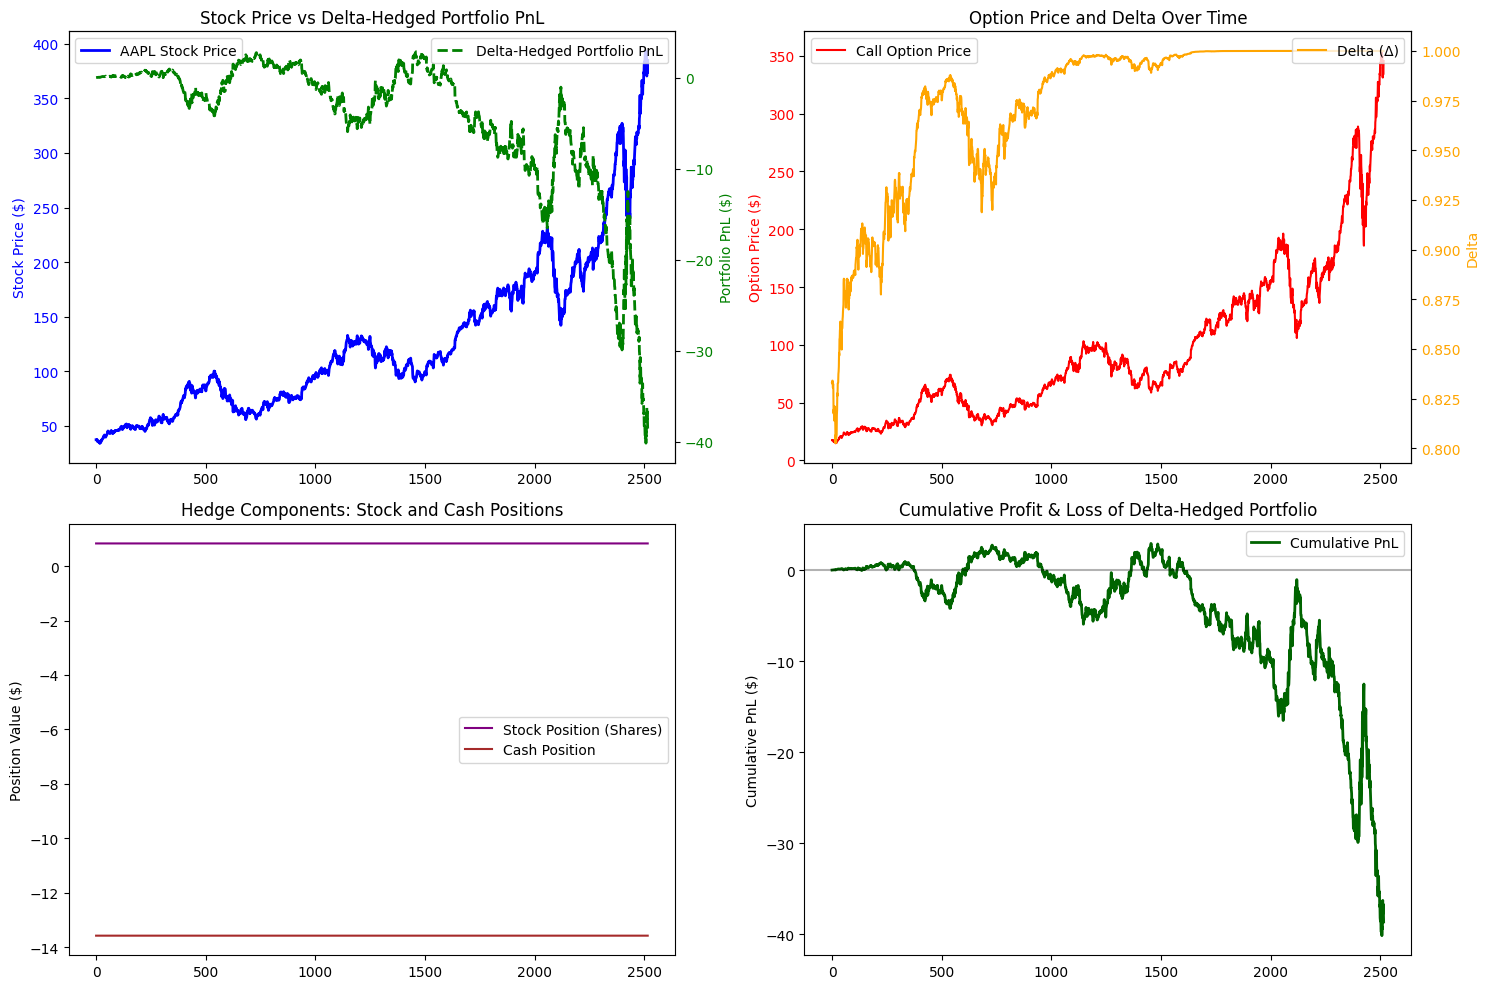

In [8]:
def run_complete_analysis():
    # Prepare data
    stock_prices = aapl_data['Close'].values

    # Simulation parameters
    params = {
        'strike': stock_prices[0] * 1.05,  # 5% OTM
        'risk_free_rate': 0.05,
        'volatility': 0.25
    }

    # Run simulation
    results = delta_hedge_simulation(stock_prices, params)

    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Stock Price vs Portfolio PnL
    ax1.plot(stock_prices, label='AAPL Stock Price', color='blue', linewidth=2)
    ax1.set_ylabel('Stock Price ($)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')

    ax1_twin = ax1.twinx()
    ax1_twin.plot(results['pnl'], label='Delta-Hedged Portfolio PnL',
                 color='green', linewidth=2, linestyle='--')
    ax1_twin.set_ylabel('Portfolio PnL ($)', color='green')
    ax1_twin.tick_params(axis='y', labelcolor='green')
    ax1_twin.legend(loc='upper right')
    ax1.set_title('Stock Price vs Delta-Hedged Portfolio PnL')

    # Plot 2: Option Price and Delta
    ax2.plot(results['option_prices'], label='Call Option Price', color='red')
    ax2.set_ylabel('Option Price ($)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.legend(loc='upper left')

    ax2_twin = ax2.twinx()
    ax2_twin.plot(results['deltas'], label='Delta (Δ)', color='orange')
    ax2_twin.set_ylabel('Delta', color='orange')
    ax2_twin.tick_params(axis='y', labelcolor='orange')
    ax2_twin.legend(loc='upper right')
    ax2.set_title('Option Price and Delta Over Time')

    # Plot 3: Hedge Components
    ax3.plot(results['stock_positions'], label='Stock Position (Shares)', color='purple')
    ax3.plot(results['cash_positions'], label='Cash Position', color='brown')
    ax3.set_ylabel('Position Value ($)')
    ax3.legend()
    ax3.set_title('Hedge Components: Stock and Cash Positions')

    # Plot 4: Cumulative PnL Breakdown
    daily_returns = np.diff(results['pnl'])
    cumulative_pnl = np.cumsum(daily_returns)
    ax4.plot(cumulative_pnl, label='Cumulative PnL', color='darkgreen', linewidth=2)
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax4.set_ylabel('Cumulative PnL ($)')
    ax4.legend()
    ax4.set_title('Cumulative Profit & Loss of Delta-Hedged Portfolio')

    plt.tight_layout()
    plt.show()

    return results

# Run the analysis
results = run_complete_analysis()

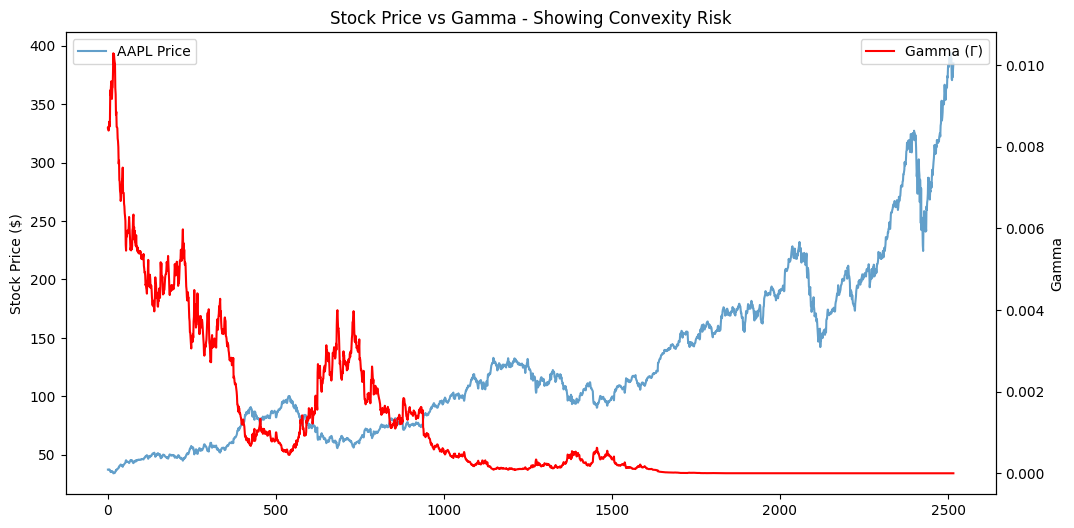

In [9]:
def calculate_gamma(S, K, T, r, sigma):
    """Calculate Gamma for the option"""
    if T <= 0:
        return 0

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    return gamma

def gamma_analysis(stock_prices, params):
    """Analyze gamma risk in the hedge"""
    gammas = []
    for i, price in enumerate(stock_prices):
        days_remaining = len(stock_prices) - i
        T_current = days_remaining / 252
        gamma = calculate_gamma(price, params['strike'], T_current,
                              params['risk_free_rate'], params['volatility'])
        gammas.append(gamma)

    return gammas

# Add gamma analysis
gammas = gamma_analysis(aapl_data['Close'].values, {
    'strike': aapl_data['Close'].iloc[0] * 1.05,
    'risk_free_rate': 0.05,
    'volatility': 0.25
})

plt.figure(figsize=(12, 6))
plt.plot(aapl_data['Close'].values, label='AAPL Price', alpha=0.7)
plt.ylabel('Stock Price ($)')
plt.legend(loc='upper left')

plt.twinx()
plt.plot(gammas, label='Gamma (Γ)', color='red')
plt.ylabel('Gamma')
plt.legend(loc='upper right')
plt.title('Stock Price vs Gamma - Showing Convexity Risk')
plt.show()

In [ ]:
def calculate_performance_metrics(results, stock_prices):
    """Calculate key performance metrics"""
    pnl = results['pnl']
    stock_returns = np.diff(stock_prices) / stock_prices[:-1]
    portfolio_returns = np.diff(pnl) / (np.mean(np.abs(pnl)) + 1e-10)  # Avoid division by zero

    metrics = {
        'Total PnL': pnl[-1] - pnl[0],
        'PnL Volatility': np.std(np.diff(pnl)),
        'Max PnL': np.max(pnl),
        'Min PnL': np.min(pnl),
        'Final Hedge Error': pnl[-1],  # Should be close to zero for perfect hedge
        'Stock Volatility': np.std(stock_returns),
        'Portfolio Volatility': np.std(portfolio_returns)
    }

    print("=== DELTA-HEDGING PERFORMANCE METRICS ===")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics

# Calculate metrics
metrics = calculate_performance_metrics(results, aapl_data['Close'].values)

=== DELTA-HEDGING PERFORMANCE METRICS ===
Total PnL: -38.6307
PnL Volatility: 0.4723
Max PnL: 2.9272
Min PnL: -40.1424
Final Hedge Error: -38.6307
Stock Volatility: 0.0173
Portfolio Volatility: 0.0918
